100%|██████████| 9.91M/9.91M [00:00<00:00, 33.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.28MB/s]
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 36825 (\N{CJK UNIFIED IDEOGRAPH-8FD9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26159 (\N{CJK UNIFIED IDEOGRAPH-662F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  fig.

我们有 60000 张图片用于训练。
我们有 10000 张图片用于考试。

第一张图片的形状: torch.Size([1, 28, 28])
第一张图片的答案 (标签): 5


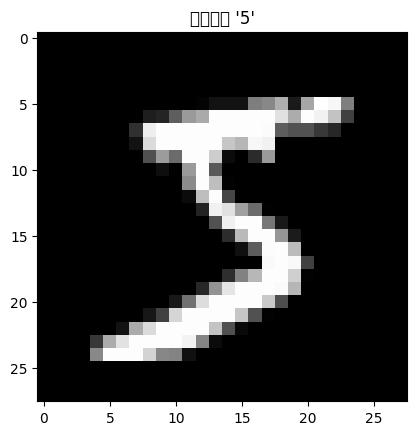

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

# 导入 torchvision，这是一个专门处理图片数据的强大工具
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor # 这是一个能把图片转换成Tensor的工具

# --- 准备教材 ---

# 1. 下载训练教材 (train_data)
#    - root="data": 教材下载到哪里
#    - train=True:  说明这是给学生“学习”用的部分
#    - download=True: 如果本地没有，就自动下载
#    - transform=ToTensor(): 这是一个非常重要的步骤！
#      它把图片从人眼看的格式(PIL Image)，转换成AI能理解的Tensor格式。
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# 2. 下载考试试卷 (test_data)
#    - train=False: 说明这是给学生“考试”用的，它在学习中绝对不能偷看！
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(f"我们有 {len(train_data)} 张图片用于训练。")
print(f"我们有 {len(test_data)} 张图片用于考试。")

# --- 让我们随便看一张图片和它的答案 ---
image, label = train_data[0]
print(f"\n第一张图片的形状: {image.shape}")
print(f"第一张图片的答案 (标签): {label}")

plt.imshow(image.squeeze(), cmap="gray") # .squeeze()是把 [1, 28, 28] 这种多余的维度去掉
plt.title(f"这是一个 '{label}'")
plt.show()


In [2]:
from torch.utils.data import DataLoader

# --- 先把教材放进“自动发牌机” ---
BATCH_SIZE = 32 # 每次看32张图片
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# --- 创造一个CNN大脑 ---
class MNIST_CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        # 第一个特征扫描模块
        self.conv_block_1 = nn.Sequential(
            # 输入通道=1(黑白), 输出通道=10(用10个扫描仪), 扫描仪大小=3x3
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # 第二个特征扫描模块
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # 2x2的总结摘要
        )
        # 第一个决策模块
        self.classifier = nn.Sequential(
            # nn.Flatten()：把扫描完的二维特征图，压平成一长串数字
            nn.Flatten(),
            # 把压平的特征，连接到一个最终的决策层
            # 10 * 14 * 14 是压平后的特征数量，10是最终的输出类别数(0-9)
            nn.Linear(in_features=10 * 14 * 14, out_features=10)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.classifier(x)
        return x

# 实例化一个学生，并把它送到GPU上（如果Colab有的话）
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MNIST_CNN_Model().to(device)

print("--- 这是我们CNN学生的大脑结构 ---")
print(model)


--- 这是我们CNN学生的大脑结构 ---
MNIST_CNN_Model(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=10, bias=True)
  )
)


In [3]:
# --- 准备教学工具 ---

# 1. 评分标准：最适合多分类问题的老师
loss_fn = nn.CrossEntropyLoss()

# 2. 反思方法：还是用强大的Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("教学工具准备好了！")


教学工具准备好了！


In [4]:
from tqdm.auto import tqdm # 这是一个能显示漂亮进度条的工具

# --- 开始上课 ---
epochs = 3 # 对于这个任务，学3遍效果就已经很好了
print("--- 教学开始 ---")

for epoch in tqdm(range(epochs)):
    # --- 训练 ---
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader):
        # 把数据也送到GPU
        X, y = X.to(device), y.to(device)

        # 1. 学生做题
        y_pred = model(X)

        # 2. 老师评分
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 计算准确率
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

        # 3. 学生反思与调整
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 计算平均损失和准确率
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    print(f"第 {epoch+1} 遍学习成果 -> 训练差距(Loss): {train_loss:.4f} | 训练准确率: {train_acc*100:.2f}%")

print("--- 教学结束 ---")


--- 教学开始 ---


  0%|          | 0/3 [00:00<?, ?it/s]

第 1 遍学习成果 -> 训练差距(Loss): 0.2232 | 训练准确率: 93.47%
第 2 遍学习成果 -> 训练差距(Loss): 0.0766 | 训练准确率: 97.77%
第 3 遍学习成果 -> 训练差距(Loss): 0.0584 | 训练准确率: 98.23%
--- 教学结束 ---



--- 毕业考试成绩 ---
考试差距(Loss): 0.0591 | 考试准确率: 98.10%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 23454 (\N{CJK UNIFIED IDEOGRAPH-5B9E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31572 (\N{CJK UNIFIED IDEOGRAPH-7B54}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26696 (\N{CJK UNIFIED IDEOGRAPH-6848}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29468 (\N{CJK UNIFIED IDEOGRAPH-731C}) missing from font(s) DejaVu Sans.
  fig.canvas

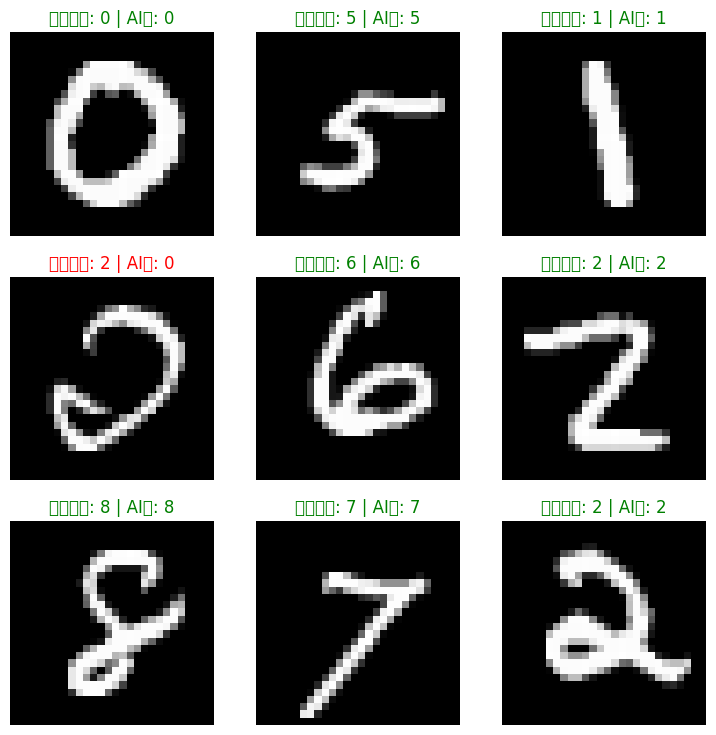

In [5]:
# --- 毕业统考 ---
model.eval()
test_loss, test_acc = 0, 0
with torch.no_grad(): # 进入考试模式，不反思
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_pred = model(X)
        test_loss += loss_fn(test_pred, y).item()
        test_acc += (torch.argmax(test_pred, dim=1) == y).sum().item() / len(test_pred)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"\n--- 毕业考试成绩 ---\n考试差距(Loss): {test_loss:.4f} | 考试准确率: {test_acc*100:.2f}%")

# --- 让我们随机抽几张卷子，看看它答得怎么样 ---
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

pred_classes = []
model.eval()
with torch.no_grad():
    for sample in test_samples:
        pred_logit = model(sample.unsqueeze(0).to(device))
        pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
        pred_classes.append(torch.argmax(pred_prob).cpu().item())

plt.figure(figsize=(9, 9))
for i, sample in enumerate(test_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    title_text = f"真实答案: {test_labels[i]} | AI猜: {pred_classes[i]}"
    # 如果猜对了是绿色，猜错了是红色
    if test_labels[i] == pred_classes[i]:
        plt.title(title_text, c="g")
    else:
        plt.title(title_text, c="r")
    plt.axis(False)
plt.show()
